<h1>Lab 4: Exploring Image Data</h1>

<h1>Business Understanding</h1>
<p>This program attempts to identify and categorize handwritten English letters. The eventual goal of this model would be for use in transcribing older documents to digital form, documents that are at risk of being lost because of their age, so that they can be preserved and accessible in the future. Interested parties would include museums and various religious sects, among others, who have a history with historical documents and wish to preserve them in the future. For all of those parties, accuracy in classifying letters is much more important than the speed at which the letters are classified, so this model is built to be highly accurate and care less about time taken.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import random
import os
# importing helperp (Code writtern as a script)
# import helper
import pandas as pd
import warnings
from sklearn.decomposition import PCA as RandomizedPCA
import string
import cv2
from skimage import color
from sklearn.model_selection import train_test_split
warnings.simplefilter("ignore")

### 1.2 Data preparation

Loading the test and training data. Functions defined in helper.py

In [2]:
"""
test_images, test_labels = helper.load_test_data()
train_images, train_labels = helper.load_train_data()

labels = { 
            0:'T-shirt/top',
            1:'Trouser',
            2:'Pullover',
            3:'Dress',
            4:'Coat',
            5:'Sandal',
            6:'Shirt',
            7:'Sneaker',
            8:'Bag',
            9:'Ankle boot'
            }
h = 28
w = 28
# Let's varify that the data is loaded correctly
print('Shape of train_images: ',train_images.shape)
print('Shape of train_labels: ',train_labels.shape)
print('Shape of test_images: ',test_images.shape)
print('Shape of test_labels: ',test_labels.shape)

# Load up a random image from training_images
random_index = random.randrange(len(train_images))
label_num_for_image = train_labels[random_index]
label = labels[label_num_for_image]
label
helper.show_image(train_images[random_index],label)
"""
images = []
letters = []
letter_change_indices = []

counter = 0
total_counter = 0
letter_limit = 1000   # Remove for final run
for letter in enumerate(string.ascii_uppercase):
    counter = 0
    letter_change_indices.append(total_counter)
    print("Processing",letter[1])
    path_folder = './Letter_Images/' + letter[1]
    for path_image in os.listdir(path_folder):
        path = path_folder + '/' + path_image
        counter+=1
        total_counter+=1
        if counter >= letter_limit: 
             # Limit to 1000 images per letter to prevent bloating the data. Remove once all data established.
            break
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = color.rgb2gray(img) # technically 
        img = np.ravel(img)
        images.append(img)
        letters.append(letter[1])
print("Total Images Processed:",total_counter)
X = np.array(images)
y = np.array(letters)
h, x = (28, 28)
# Split training and testing data now
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

Processing A
Processing B
Processing C
Processing D
Processing E
Processing F
Processing G
Processing H
Processing I
Processing J
Processing K
Processing L
Processing M
Processing N
Processing O
Processing P
Processing Q
Processing R
Processing S
Processing T
Processing U
Processing V
Processing W
Processing X
Processing Y
Processing Z
Total Images Processed: 26000


This shows that the dataset has been loaded correctly.

Preview some random images from the training set.

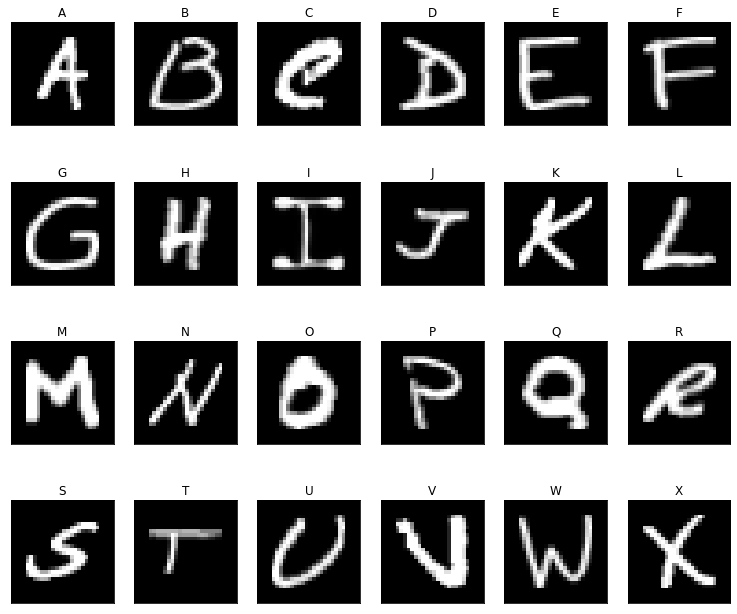

In [3]:
# Let's look at a few more images with labels
def plot_gallery(images, titles,labels, h=28, w=28, n_row=4, n_col=6, uselabels=True):
    """Helper function to plot a gallery of items"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        index = letter_change_indices[i]
        plt.imshow(images[index].reshape((h, w)), cmap=plt.cm.gray)
        if(uselabels):
            plt.title(labels[index], size=12)
        else:
            plt.title(titles[index], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(X, y, letters, 28, 28)# defaults to showing a 3 by 6 subset of the images

## 2. Evaluation

### 2.1 Evaluate metric

Let's first take a look at the number of instances in each class within training data. 

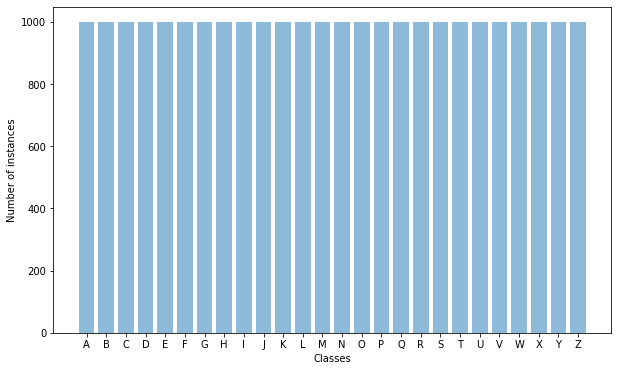

In [4]:
u, class_counts = np.unique(letters, return_counts=True)
y_pos = np.arange(len(class_counts))
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(y_pos, class_counts ,align='center', alpha=0.5)
plt.xticks(y_pos, [x for x in np.unique(letters)])
plt.ylabel('Number of instances')
plt.xlabel('Classes')
plt.show()

<p>All the classes that reach 1000 were limited to 1000 manually to prevent dataset bloating as well as keeping class distributions even, because multiple letters (F, I) had far fewer examples than some other letters.</p>


<h1>2.2: Evaluation Methodology</h1>
<p>We are going to be using stratified 10-fold validation for this model because the amount of data (26000 images) is on the smaller side, so we want to prevent as much overfitting and training biases as we can. To evaluate our models, we use accuracy score, because we want to track the performance over a series of letters by the model. We care mostly about the true postive rate, but don't really care enough about false positives to switch over to a more critical model like precision score or f1 score.</p>

## Model (Multi layer perceptron)

### 3.1 Model with one hidden layer

In [5]:
from scipy.special import expit
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                firstLayerActivationFunction = 'sigmoid',
                costFunction = 'quadratic'):# Edit by Zheng Li
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.firstLayerActivationFunction = firstLayerActivationFunction  # Edit by Zheng Li
        self.costFunction = costFunction
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        if self.costFunction =='quadratic':
            cost = np.mean((Y_enc-A3)**2)
        elif self.costFunction =='cross entropy':
            cost = -[Y_enc*math.log(A3)+(1-Y_enc)*math.log(1-A3)]    
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [6]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.firstLayerActivationFunction =='sigmoid': # Edit by Zheng Li
            A2 = self._sigmoid(Z1)
        elif self.firstLayerActivationFunction =='linear':# Edit by Zheng Li
            A2 = Z1  
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        
        # for each instance's activations 
        for (a1,a2,a3,y) in zip(A1,A2.T,A3.T,Y_enc.T):
            dJ_dz2 = -2*(y - a3)*a3*(1-a3)
            dJ_dz1 = dJ_dz2 @ W2 @ np.diag(a2*(1-a2))
            grad2 += dJ_dz2[:,np.newaxis]  @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        self.grad_w1_ = np.zeros((self.epochs))
        self.grad_w2_ = np.zeros((self.epochs))

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)
            
            self.grad_w1_[i] = np.mean(np.absolute(grad1))
            self.grad_w2_[i] = np.mean(np.absolute(grad2))

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self
    
    def get_gradients(self):
        return self.grad_w1_, self.grad_w2_

In [7]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        if self.costFunction =='quadratic':
            sigma2 = -2*(Y_enc-A3)*A3*(1-A3)
        elif self.costFunction =='cross entropy':
            sigma2 = (A3-Y_enc)
            # vectorized backpropagation   
        grad2 = sigma2 @ A2.T

        sigma1 = (W2.T @ sigma2)*A2*(1-A2)
        grad1 = sigma1[1:,:] @ A1
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [8]:
class ThreeLayerPerceptronBase(object):
    def __init__(self, n_hidden1=60, n_hidden2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None,
                firstLayerActivationFunction = 'sigmoid',
                secondLayerActivationFunction = 'sigmoid',
                costFunction = 'quadratic'):
        np.random.seed(random_state)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.firstLayerActivationFunction = firstLayerActivationFunction  # Edit by Zheng Li
        self.secondLayerActivationFunction = secondLayerActivationFunction
        self.costFunction = 'quadratic'
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden1, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden1 + 1)*self.n_hidden2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden2, self.n_hidden1 + 1) # reshape to be W
        
        W3_num_elems = (self.n_hidden2 + 1)*self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden2 + 1)
        
        return W1, W2, W3
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))
    
    def _cost(self,A4,Y_enc,W1,W2,W3):
        '''Get the objective function value'''
        
        if self.costFunction =='quadratic':
            cost = np.mean((Y_enc-A4)**2)
        elif self.costFunction =='cross entropy':
            cost = -[Y_enc*math.log(A4)+(1-Y_enc)*math.log(1-A4)]    
#         cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

In [9]:
class ThreeLayerPerceptron(ThreeLayerPerceptronBase):
    
    def _feedforward(self, X, W1, W2, W3):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer1.
        W2: Weight matrix for hidden layer1 -> hidden layer2
        W3: Weight matrix for hidden layer2 -> output layer.
        ----------
        A1-A4 : activations into layer (or output layer)
        Z1-Z3 : layer inputs 

        """
        A1 = self._add_bias_unit(X, how='column')
        Z1 = W1 @ A1.T
        if self.firstLayerActivationFunction =='sigmoid': # Edit by Zheng Li
            A2 = self._sigmoid(Z1)
        elif self.firstLayerActivationFunction =='linear':# Edit by Zheng Li
            A2 = Z1  
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        if self.secondLayerActivationFunction =='sigmoid': # Edit by Zheng Li
            A3 = self._sigmoid(Z2)
        elif self.secondLayerActivationFunction =='linear':# Edit by Zheng Li
            A3 = Z2
        
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        # backpropagation
        grad1 = np.zeros(W1.shape)
        grad2 = np.zeros(W2.shape)
        grad3 = np.zeros(W3.shape)

        # for each instance's activations 
        for (a1,a2,a3,a4,y) in zip(A1,A2.T,A3.T,A4.T,Y_enc.T):
            dJ_dz3 = -2*(y - a4)*a4*(1-a4)
            dJ_dz2 = dJ_dz3 @ W3 @ np.diag(a3*(1-a3))
            dJ_dz1 = dJ_dz2[1:]@ W2 @ np.diag(a2*(1-a2))
            
            grad3 += dJ_dz3[:,np.newaxis]  @ a3[np.newaxis,:]
            grad2 += dJ_dz2[1:,np.newaxis] @ a2[np.newaxis,:]
            grad1 += dJ_dz1[1:,np.newaxis] @ a1[np.newaxis,:] 
            # don't incorporate bias term in the z1 gradient 
            # (its added in a2 from another layer)
            

        # regularize weights that are not bias terms
        grad1[:, 1:] += (W1[:, 1:] * self.l2_C)
        grad2[:, 1:] += (W2[:, 1:] * self.l2_C)
        grad3[:, 1:] += (W3[:, 1:] * self.l2_C)
        
        return grad1, grad2, grad3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()
        self.grad_w1_ = np.zeros((self.epochs))
        self.grad_w2_ = np.zeros((self.epochs))
        self.grad_w3_ = np.zeros((self.epochs))

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data,self.W1,self.W2,self.W3)
            
            cost = self._cost(A4,Y_enc,self.W1,self.W2,self.W3)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2, W3=self.W3)
            
            self.grad_w1_[i] = np.mean(np.absolute(grad1))
            self.grad_w2_[i] = np.mean(np.absolute(grad2))
            self.grad_w3_[i] = np.mean(np.absolute(grad3))
            
            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3
            

        return self
    
    def get_gradients(self):
        return self.grad_w1_, self.grad_w2_, self.grad_w3_

In [10]:
class ThreeLayerPerceptronVectorized(ThreeLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation.
        """
        if self.costFunction =='quadratic':
            sigma3 = -2*(Y_enc-A4)*A4*(1-A4)
        elif self.costFunction =='cross entropy':
            sigma3 = (A4-Y_enc)
            # vectorized backpropagation   
        grad3 = sigma3 @ A3.T
        
        sigma2 = (W3.T @ sigma3)*A3*(1-A3)
        grad2 = sigma2[1:,:] @ A2.T
        
        sigma1 = (W2.T @ sigma2[1:,:])*A2*(1-A2)
        grad1 = sigma1[1:,:] @ A1
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3
    

### 3.2 Parameter tuning

In [11]:
from sklearn.model_selection import train_test_split


params = dict(n_hidden = 50,
              C=0.01, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              # secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

In [12]:
# Keep the original x_test and y_test to separate test and validation
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', TwoLayerPerceptronVectorized(**params))])

pipe_lr.fit(X_val_train, y_val_train)
y_pred = pipe_lr.predict(X_val_test)
y_pred_letters = []
for i in y_pred:
    y_pred_letters.append(u[i])
print("Accuracy score of:",accuracy_score(y_val_test,y_pred_letters))

Accuracy score of: 0.18623676612127046


In [13]:
eta = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
score = []
for i in eta:
    params['eta']=i
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=0)),
                    ('clf', TwoLayerPerceptronVectorized(**params))])

    pipe_lr.fit(X_val_train, y_val_train)
    y_pred = pipe_lr.predict(X_val_test)
    y_pred_letters = []
    for ii in y_pred:
        y_pred_letters.append(u[ii])
    scr = accuracy_score(y_val_test,y_pred_letters)
    score.append(scr)
    print("Accuracy score of: %.3f for learning rate: %f"%(scr,i))

Accuracy score of: 0.033 for learning rate: 0.100000
Accuracy score of: 0.040 for learning rate: 0.010000
Accuracy score of: 0.051 for learning rate: 0.001000
Accuracy score of: 0.186 for learning rate: 0.000100
Accuracy score of: 0.060 for learning rate: 0.000010
Accuracy score of: 0.033 for learning rate: 0.000001


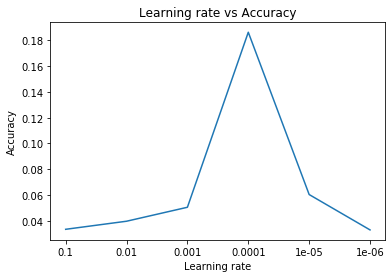

In [14]:
x_ = list(i for i in range(6))
plt.plot(score)
plt.xticks(x_,eta)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.title("Learning rate vs Accuracy")
plt.show()

According to the learning rate vs Accuracy, learning rate of 0.0001 has the best performance, therefore, the following analysis will use the value of 0.0001 as learning rate. However, recognizing that the best performing learning rate is still dismally bad, hopefully one of the other tuning parameters will do better.

In [15]:
C = [10,1, 0.1, 0.01, 0.001, 0.0001]
params['eta'] = 0.0001
score = []
for i in C:
    params['C']=i
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', TwoLayerPerceptronVectorized(**params))])
    pipe_lr.fit(X_val_train, y_val_train)
    y_pred = pipe_lr.predict(X_val_test)
    y_pred_letters = []
    for ii in y_pred:
        y_pred_letters.append(u[ii])
    scr = accuracy_score(y_val_test,y_pred_letters)
    score.append(scr)
    print("Accuracy score of: %.3f for Regularization term C: %f"%(scr,i))

Accuracy score of: 0.204 for Regularization term C: 10.000000
Accuracy score of: 0.188 for Regularization term C: 1.000000
Accuracy score of: 0.187 for Regularization term C: 0.100000
Accuracy score of: 0.186 for Regularization term C: 0.010000
Accuracy score of: 0.186 for Regularization term C: 0.001000
Accuracy score of: 0.186 for Regularization term C: 0.000100


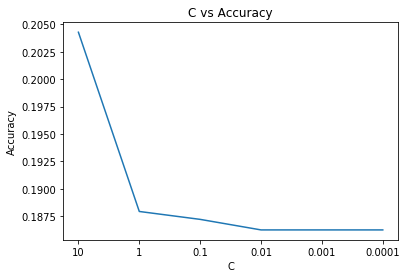

In [16]:
x_ = list(i for i in range(6))
plt.plot(score)
plt.xticks(x_,C)
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C vs Accuracy")
plt.show()

According to the C vs Accuracy, C =10 has the best performance, therefore, the following analysis will use the value of 10 as regularization term

In [17]:
params = dict(n_hidden = 50,
              C=10, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              # secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

epochs = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
score_test = []
score_val = []

for i in epochs:
    params['epochs']=i
    pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', TwoLayerPerceptronVectorized(**params))])
    pipe_lr.fit(X_val_train, y_val_train)
    y_pred = pipe_lr.predict(X_val_test)
    y_pred_letters = []
    for ii in y_pred:
        y_pred_letters.append(u[ii])
    # Validation not testing accuracy now
    y_pred_val = pipe_lr.predict(X_test)
    y_pred_val_letters = []
    for ii in y_pred_val:
        y_pred_val_letters.append(u[ii])
    test_scr = accuracy_score(y_val_test,y_pred_letters)
    val_scr = accuracy_score(y_test,y_pred_val_letters)
    score_test.append(test_scr)
    score_val.append(val_scr)
    print("Test Accuracy: %.3f Validation Accuracy: %.3f for Epochs: %i"%(test_scr, val_scr, i))

Test Accuracy: 0.204 Validation Accuracy: 0.194 for Epochs: 100
Test Accuracy: 0.334 Validation Accuracy: 0.319 for Epochs: 200
Test Accuracy: 0.444 Validation Accuracy: 0.433 for Epochs: 300
Test Accuracy: 0.562 Validation Accuracy: 0.556 for Epochs: 400
Test Accuracy: 0.640 Validation Accuracy: 0.635 for Epochs: 500
Test Accuracy: 0.725 Validation Accuracy: 0.730 for Epochs: 600
Test Accuracy: 0.761 Validation Accuracy: 0.769 for Epochs: 700
Test Accuracy: 0.785 Validation Accuracy: 0.797 for Epochs: 800
Test Accuracy: 0.805 Validation Accuracy: 0.811 for Epochs: 900
Test Accuracy: 0.821 Validation Accuracy: 0.820 for Epochs: 1000


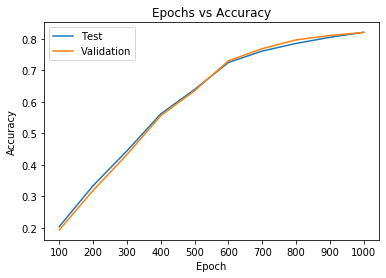

In [18]:
x_ = list(i for i in range(10))
plt.plot(score_test)
plt.plot(score_val)
plt.xticks(x_,epochs)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend(["Test","Validation"])
plt.show()

In [19]:
# Testing 2-Layer vs 3-Layer
params2 = dict(n_hidden = 50,
              C=10, # tradeoff L2 regularizer
              epochs=1000, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

params3 = dict(n_hidden1=128,
               n_hidden2= 64,
              C=10, # tradeoff L2 regularizer
              epochs=1000, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

pipe_lr_2 = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', TwoLayerPerceptronVectorized(**params2))])

%time pipe_lr_2.fit(X_train, y_train)
y_pred = pipe_lr_2.predict(X_test)
y_pred_letters = []
for i in y_pred:
    y_pred_letters.append(u[i])
print("Accuracy score of: ",accuracy_score(y_test,y_pred_letters),"for 2 layer perceptron.")

pipe_lr_3 = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', ThreeLayerPerceptronVectorized(**params3))])

%time pipe_lr_3.fit(X_train, y_train)
y_pred = pipe_lr_3.predict(X_test)
y_pred_letters = []
for i in y_pred:
    y_pred_letters.append(u[i])
print("Accuracy score of: ",accuracy_score(y_pred_letters,y_test),"for 3 layer perceptron.")

Wall time: 1min 45s
Accuracy score of:  0.8340712223291626 for 2 layer perceptron.
Wall time: 3min 18s
Accuracy score of:  0.8333012512030799 for 3 layer perceptron.


<p>In the future, we will be using the 2-layer perceptron because it is faster at little-to-no cost to accuracy. As seen above, the two layer perceptron actually out-performs the 3-layer perceptron by 0.1%, but in a much faster time.</p>

<h1>Graphing Gradient Magnitudes</h1>

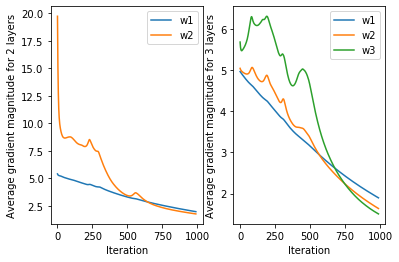

In [20]:
w1_2, w2_2 = pipe_lr_2['clf'].get_gradients()
w1_3, w2_3, w3_3 = pipe_lr_3['clf'].get_gradients()

ax1 = plt.subplot(1,2,1)
plt.plot(abs(w1_2[10:]), label='w1')
plt.plot(abs(w2_2[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude for 2 layers')
plt.xlabel('Iteration')

ax2 = plt.subplot(1,2,2)
plt.plot(abs(w1_3[10:]), label='w1')
plt.plot(abs(w2_3[10:]), label='w2')
plt.plot(abs(w3_3[10:]), label='w3')
plt.legend()
plt.ylabel('Average gradient magnitude for 3 layers')
plt.xlabel('Iteration')
plt.show()

Awesome! The gradients all continue to minimize as epochs continue forward. 

In [21]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10,
                        random_state=1, shuffle=True).split(X, y)
params = dict(n_hidden=50,
              C=10, # tradeoff L2 regularizer
              epochs=1000, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              # secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', TwoLayerPerceptronVectorized(**params))])

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train, y_train)
    y_pred = pipe_lr.predict(X_test)
    y_pred_letters = []
    for i in y_pred:
        y_pred_letters.append(u[i])
    score = accuracy_score(y_test,y_pred_letters)
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.834
Fold: 2, Acc: 0.830
Fold: 3, Acc: 0.827
Fold: 4, Acc: 0.824
Fold: 5, Acc: 0.827
Fold: 6, Acc: 0.825
Fold: 7, Acc: 0.828
Fold: 8, Acc: 0.826
Fold: 9, Acc: 0.819
Fold: 10, Acc: 0.828

CV accuracy: 0.827 +/- 0.004


### Given the best parameters, we managed to reach 82.7%+/- 0.004 test accuracy

### 3.3 Performance Comparison 

In [22]:
from sklearn import __version__ as sklearn_version
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

print("Sci-kit Learn Implementation")
print(sklearn_version)
# these values have been hand tuned
params = dict(hidden_layer_sizes=(50, ), 
                    activation='logistic', 
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size='auto', # min of 200, num_samples
                    learning_rate='constant', 
                    learning_rate_init=0.0001, # only SGD
                    power_t=0.5,    # only SGD
                    max_iter=800, 
                    shuffle=True, 
                    random_state=1, 
                    tol=1e-9, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=True, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.1, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', MLPClassifier(**params))])

%time pipe_lr.fit(X_train,y_train)
yhat = pipe_lr.predict(X_test)
print('Validation Acc:',accuracy_score(y_test,yhat))

Sci-kit Learn Implementation
0.21.2
Wall time: 1min 39s
Validation Acc: 0.7990375360923966


In [23]:
print("Our Implementation")

params = dict(n_hidden=50,
              C=10, # tradeoff L2 regularizer
              epochs=1000, # iterations
              eta=0.0001,  # learning rate
              random_state=1,
              firstLayerActivationFunction='sigmoid',
              # secondLayerActivationFunction='sigmoid',
              costFunction = 'quadratic')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=400,random_state=1)),
                    ('clf', TwoLayerPerceptronVectorized(**params))])

%time pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
y_pred_letters = []
for i in y_pred:
    y_pred_letters.append(u[i])
print("Accuracy score of: ",accuracy_score(y_test,y_pred_letters))

Our Implementation
Wall time: 1min 44s
Accuracy score of:  0.8340712223291626


The comparison between our implementation and sklearn has been conducted, our best performance reaches 83.41% on the validation set and the sklearn reaches 79.90% on the validation set. In terms of running time, our implementation used 1min 44s and sklearn used 1min 39s. In all, the sklearn barely outperforms our implementation in computational time but our performs not on accuracy. It is worth mentioning that we have used an additional layer for our MLP(three layer MLP) and the performance of our implementation could be improved further by applying optimization techniques like dropout, various activation functions, softmax, etc. 

## Exceptional work
We all participated in the research study, which qualifies us to not have to complete this part of Lab 4.